# Density normalization: 2nd step: normalize the rest of scans

The X-ray CT scans can be stacked to form 3D numpy arrays saved as TIFF files. In our case, we saved the scans with 8-bit resoltion, so that each voxel has a density value ranging from `0` to `255`. The X-ray CT scan measures **relative** density rather than absolute density. That is, the lowest density voxel in the object gets treated as density `0` while the densest point is treated as `255` with a linear interpolation for the rest of voxels. This means that two different sets of barley spikes could report vastly different densities!

We assume that every barley spike has essentially the same density, and that relative differences are caused by specks of metal or other material. Before going into any image processing and cleanup, we must normalize the densities, that is, make sure that barley spikes report the same density across all scans.

The strategy is to take the densities reported in scan `S010.tif` as our ground truth, and then adjust the rest of scans to fit such ground truth. The selection of `S010.tif` was arbitrary.

In [1]:
import tifffile as tf
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import importlib

## Load the ground-truth values

Define destination, and original scan file paths.

**Note**: The destination folder must contain **two** subfolders named `hists` and `normalize` to save the adjusted histogram plots and the model coefficients, respectively.

More details on these below.

In [2]:
dst = '../preproc/raw/'
filepath  = '../preproc/raw/S017.tif'

Load the ground truth values:
- `hist0`: The density histogram of `S010.tif`: how many voxels have density value $\rho$ for $\rho=0,1,\ldots,255$.
- `y`: The three important scan peaks corresponding to density of
    - Air = 21
    - Foam = 45
    - Grain = 225
- `anchors`: Corresponding density quantiles
    - 1.02% or voxels report a density lower than 21
    - 60.3% of voxels report a density lower than 45
    - 99.9% of voxels report a density lower than 225

In [7]:
hist0 = np.loadtxt(src+'normalization_hist.csv', dtype='int', delimiter=',')
y = np.loadtxt(src+'normalization_yvals.csv', dtype='int', delimiter=',')
anchors = np.loadtxt(src+'normalization_anchors.csv', dtype='float', delimiter=',')
print(y)
print(anchors)

[ 45 225  21]
[0.60388128 0.99935836 0.01015148]


## Load the raw scan to normalize

Load the scan to normalize and compute its density histogram with 256 bins, as voxels can take up to 256 different density values.

- The number of bins is actually deduced from the TIFF file itself

In [8]:
src, fname = os.path.split(filepath)
src += '/'
bname = os.path.splitext(fname)[0]
img = tf.imread(src+fname)

hist,bins = np.histogram(img,bins=2**(img.dtype.itemsize*8),range=(0,2**(img.dtype.itemsize*8)))
tot = img.size
cumul = np.cumsum(hist)

## Find the quantiles

Find which density values correspond to the reference `anchors` quantiles. 

- In this case, we have 22.6, 125.8, and 7.7 as the density values corresponding to the 0.60, 0.99, and 0.01 quantiles respectively.

In [25]:
x = np.zeros(len(anchors))
for i,a in enumerate(anchors):
    for j,s in enumerate(cumul):
        if s>a*tot:
            print('[ {} , {:03d} ]:\t {} > {:.3f}*{}\t = {:.0f}'.format(i,j,s,a,tot,a*tot))
            #print('[',i,',',j,']: ',s,'>',a,'*',tot,'=',a*tot)
            break
    if j > 0:
        x[i] = j-1+(a*tot-cumul[j-1])/(cumul[j]-cumul[j-1])
    else:
        x[i] = 0
print('\n',x)

[ 0 , 023 ]:	 3419292358 > 0.604*5072145000	 = 3062973423
[ 1 , 126 ]:	 5068980276 > 0.999*5072145000	 = 5068890515
[ 2 , 008 ]:	 58395181 > 0.010*5072145000	 = 51489759

 [ 22.5753508  125.76296157   7.72714328]


## Fit a quadratic model

- Compute the parabola that goes through (45,22.6), (225, 125.8), and (21,7.8)

In [26]:
npz = np.polyfit(x,y,2)
print(npz)

[1.08474482e-03 1.58348625e+00 8.69940613e+00]


## Adjust the rest of the density values according to the parabola.

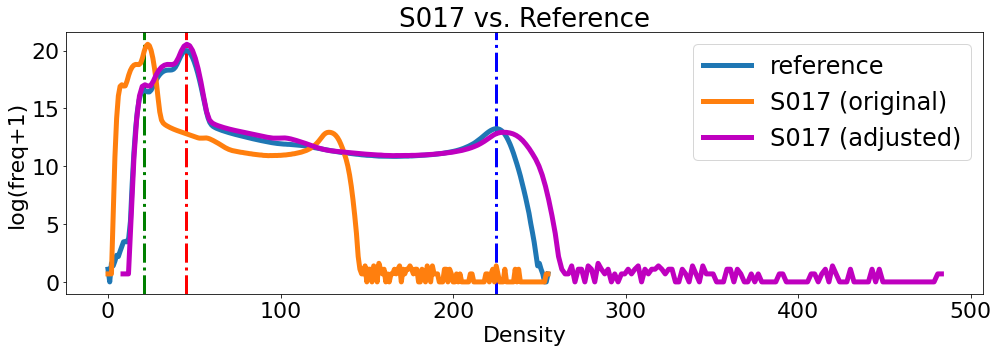

In [29]:
fig, ax = plt.subplots(figsize=(14,5))
lw = 3

ax.axvline(y[0], ls='-.', lw=lw, c='r')
ax.axvline(y[1], ls='-.', lw=lw, c='b')
ax.axvline(y[2], ls='-.', lw=lw, c='g')

ax.plot([b for b in bins[:-1]],
        [np.log(h+1) for h in hist0], 
        lw=lw+2, label = 'reference')
ax.plot([b for b in bins[:-1]],
        [np.log(h+1) for h in hist], 
        lw=lw+2, label = bname + ' (original)')
ax.plot([npz[0]*b*b + npz[1]*b + npz[2] for b in bins[:-1]],
        [np.log(h+1) for h in hist], 
        lw=lw+2, label = bname + ' (adjusted)', c='m')

ax.set_xlabel("Density", fontsize=22)
ax.set_ylabel("log(freq+1)", fontsize=22)
ax.set_title(bname + ' vs. Reference', fontsize=26)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)
plt.tight_layout()

plt.savefig(dst+'hists/' + bname+'_normalization++.jpg', dpi=175, format='jpg', pil_kwargs={'optimize':True})

## Save the polynomial model coefficients

In [ ]:
np.savetxt(dst+'normalize/' + bname + '_yvals.csv', npz, delimiter=',', fmt='%.18e', header=bname)a